✅ Step 0: Environment setup complete.

✅ Step 1: concepts.csv loaded successfully.


/var/folders/h7/l0hj74bd2vqdz0r68qj78nd80000gn/T/ipykernel_17767/1502101650.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_concepts['TypeName'], palette='viridis', order=order)


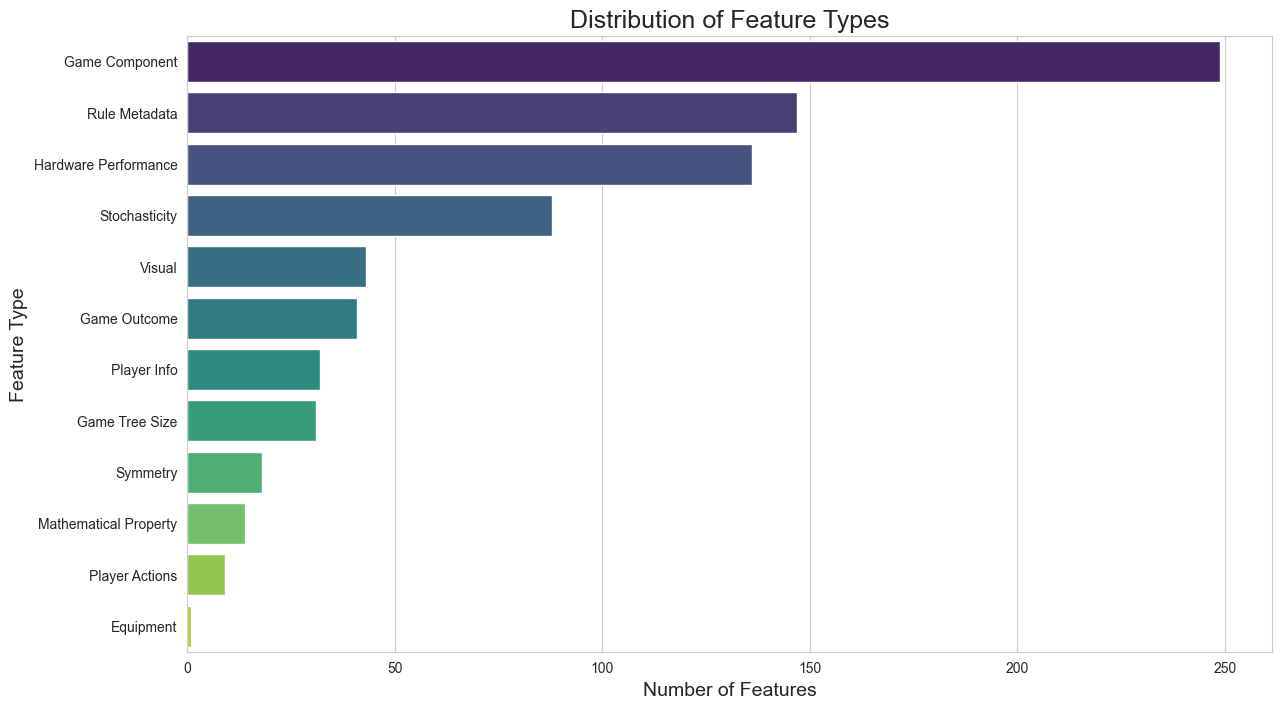

In [2]:
# --- Step 0: Environment Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Apply professional styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
pd.set_option('display.max_columns', None)
print("✅ Step 0: Environment setup complete.")

# --- Step 1: Analyze concepts.csv ---
try:
    df_concepts = pd.read_csv('../data/concepts.csv')
    print("\n✅ Step 1: concepts.csv loaded successfully.")
except FileNotFoundError:
    print("❌ ERROR: '../data/concepts.csv' not found. Please check the file path.")
    exit()

# --- Step 1 (Upgraded): Analyze concepts.csv with Names ---
# ... (加载 df_concepts 的代码不变) ...

# !! NEW: Define the mapping from TypeId to a meaningful name !!
# NOTE: This is an EXAMPLE map. We need to find the true definitions.
type_id_to_name_map = {
    5: 'Game Component', 7: 'Rule Metadata', 6: 'Hardware Performance', 11: 'Stochasticity',
    9: 'Visual', 10: 'Game Outcome', 8: 'Player Info', 1: 'Game Tree Size',
    12: 'Symmetry', 4: 'Mathematical Property', 3: 'Player Actions', 2: 'Equipment'
}

# Apply the mapping to create a new, readable column
df_concepts['TypeName'] = df_concepts['TypeId'].map(type_id_to_name_map)

# --- UPGRADED PLOT ---
plt.figure(figsize=(14, 8)) # Made it a bit wider for longer names
# Use the new 'TypeName' for the y-axis
order = df_concepts['TypeName'].value_counts().index
sns.countplot(y=df_concepts['TypeName'], palette='viridis', order=order)

plt.title('Distribution of Feature Types')
plt.xlabel('Number of Features')
plt.ylabel('Feature Type') # Changed from 'Type ID'
plt.show()

In [3]:
# --- Step 2: Load and Strategically Clean train.csv ---
try:
    df_train = pd.read_csv('../data/train.csv')
    print(f"\n✅ Step 2: train.csv loaded successfully. Initial shape: {df_train.shape}")
except FileNotFoundError:
    print("❌ ERROR: '../data/train.csv' not found. Please check the file path.")
    exit()

# --- Perform Cleaning ---

# 1. Drop ID, high-cost text columns, and other non-feature columns
# We also drop the win/loss/draw columns as they directly constitute the target and are not present in the test set.
cols_to_drop_initial = ['Id', 'GameRulesetName', 'EnglishRules', 'LudRules', 
                        'num_wins_agent1', 'num_draws_agent1', 'num_losses_agent1']

# Check which columns actually exist before trying to drop them
existing_cols_to_drop = [col for col in cols_to_drop_initial if col in df_train.columns]
df_train.drop(columns=existing_cols_to_drop, inplace=True)
print(f"-> Dropped initial non-feature and target-related columns. Current shape: {df_train.shape}")

# 2. Drop constant features
constant_cols = [col for col in df_train.columns if df_train[col].nunique() == 1]
if constant_cols:
    df_train.drop(columns=constant_cols, inplace=True)
    print(f"-> Dropped {len(constant_cols)} constant features. Final shape: {df_train.shape}")
else:
    print("-> No constant features found.")

print("\n✅ Cleaning complete. Data is ready for core feature engineering.")
print("\nPreview of the cleaned data:")
print(df_train.head())


✅ Step 2: train.csv loaded successfully. Initial shape: (233234, 814)
-> Dropped initial non-feature and target-related columns. Current shape: (233234, 807)
-> Dropped 198 constant features. Final shape: (233234, 609)

✅ Cleaning complete. Data is ready for core feature engineering.

Preview of the cleaned data:
                                   agent1  \
0  MCTS-ProgressiveHistory-0.1-MAST-false   
1  MCTS-ProgressiveHistory-0.1-MAST-false   
2   MCTS-ProgressiveHistory-0.1-MAST-true   
3   MCTS-ProgressiveHistory-0.1-MAST-true   
4   MCTS-ProgressiveHistory-0.1-MAST-true   

                                        agent2  Stochastic  Asymmetric  \
0  MCTS-ProgressiveHistory-0.6-Random200-false           0           0   
1                  MCTS-UCB1GRAVE-0.6-NST-true           0           0   
2                      MCTS-UCB1-0.1-NST-false           0           0   
3                      MCTS-UCB1-0.6-NST-false           0           0   
4       MCTS-UCB1GRAVE-1.41421356237-NST-fa

In [4]:
# --- Step 3: Core Feature Engineering - Parse Agent Columns ---

def parse_agent_strings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Parses the agent1 and agent2 string columns into 8 new feature columns.
    Converts new columns to appropriate data types.
    Drops the original agent columns.       
    """
    df_copy = df.copy()
    
    # --- Parse agent1 ---
    # The split creates a new DataFrame with parts of the string
    agent1_parts = df_copy['agent1'].str.split('-', expand=True)
    
    # Assign new columns based on the parsed parts
    df_copy['agent1_selection'] = agent1_parts[1]
    df_copy['agent1_exploration'] = agent1_parts[2].astype(float)
    df_copy['agent1_playout'] = agent1_parts[3]
    df_copy['agent1_score_bounds'] = agent1_parts[4].map({'true': 1, 'false': 0}).astype(int)

    # --- Parse agent2 ---
    agent2_parts = df_copy['agent2'].str.split('-', expand=True)
    
    df_copy['agent2_selection'] = agent2_parts[1]
    df_copy['agent2_exploration'] = agent2_parts[2].astype(float)
    df_copy['agent2_playout'] = agent2_parts[3]
    df_copy['agent2_score_bounds'] = agent2_parts[4].map({'true': 1, 'false': 0}).astype(int)
    
    # --- Clean up ---
    # Drop the original, now redundant, agent columns
    df_copy.drop(columns=['agent1', 'agent2'], inplace=True)
    
    print("✅ Agent strings parsed successfully.")
    print("-> 8 new features created.")
    print("-> Original 'agent1' and 'agent2' columns dropped.")
    
    return df_copy

# Apply the function to our DataFrame
df_featured = parse_agent_strings(df_train)

# Display the head of the new features to verify
print("\n--- Preview of New Core Features ---")
new_feature_cols = [
    'agent1_selection', 'agent1_exploration', 'agent1_playout', 'agent1_score_bounds',
    'agent2_selection', 'agent2_exploration', 'agent2_playout', 'agent2_score_bounds'
]
print(df_featured[new_feature_cols].head())

# Also check their data types
print("\n--- Data Types of New Features ---")
print(df_featured[new_feature_cols].info())

✅ Agent strings parsed successfully.
-> 8 new features created.
-> Original 'agent1' and 'agent2' columns dropped.

--- Preview of New Core Features ---
     agent1_selection  agent1_exploration agent1_playout  agent1_score_bounds  \
0  ProgressiveHistory                 0.1           MAST                    0   
1  ProgressiveHistory                 0.1           MAST                    0   
2  ProgressiveHistory                 0.1           MAST                    1   
3  ProgressiveHistory                 0.1           MAST                    1   
4  ProgressiveHistory                 0.1           MAST                    1   

     agent2_selection  agent2_exploration agent2_playout  agent2_score_bounds  
0  ProgressiveHistory            0.600000      Random200                    0  
1           UCB1GRAVE            0.600000            NST                    1  
2                UCB1            0.100000            NST                    0  
3                UCB1            0.60000

/var/folders/h7/l0hj74bd2vqdz0r68qj78nd80000gn/T/ipykernel_17767/1617864144.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_featured[feature_to_analyze],
/var/folders/h7/l0hj74bd2vqdz0r68qj78nd80000gn/T/ipykernel_17767/1617864144.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='utility_agent1', y=feature_to_analyze, data=df_featured,


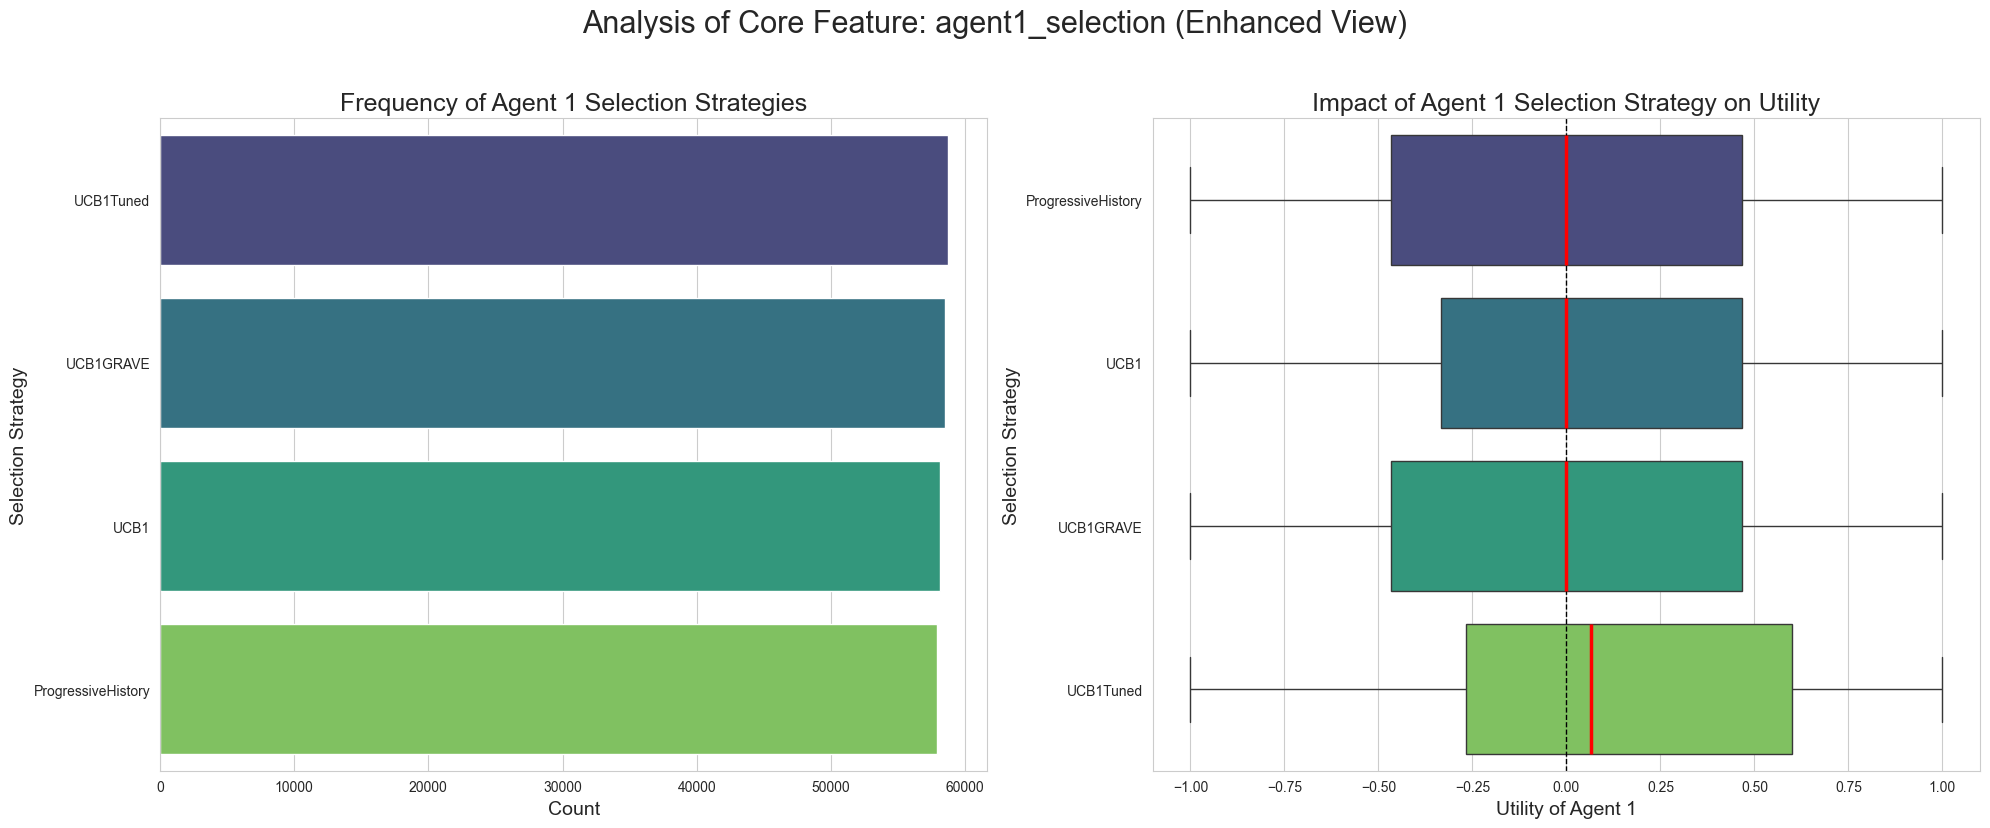

/var/folders/h7/l0hj74bd2vqdz0r68qj78nd80000gn/T/ipykernel_17767/1617864144.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_featured[feature_to_analyze],
/var/folders/h7/l0hj74bd2vqdz0r68qj78nd80000gn/T/ipykernel_17767/1617864144.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='utility_agent1', y=feature_to_analyze, data=df_featured,


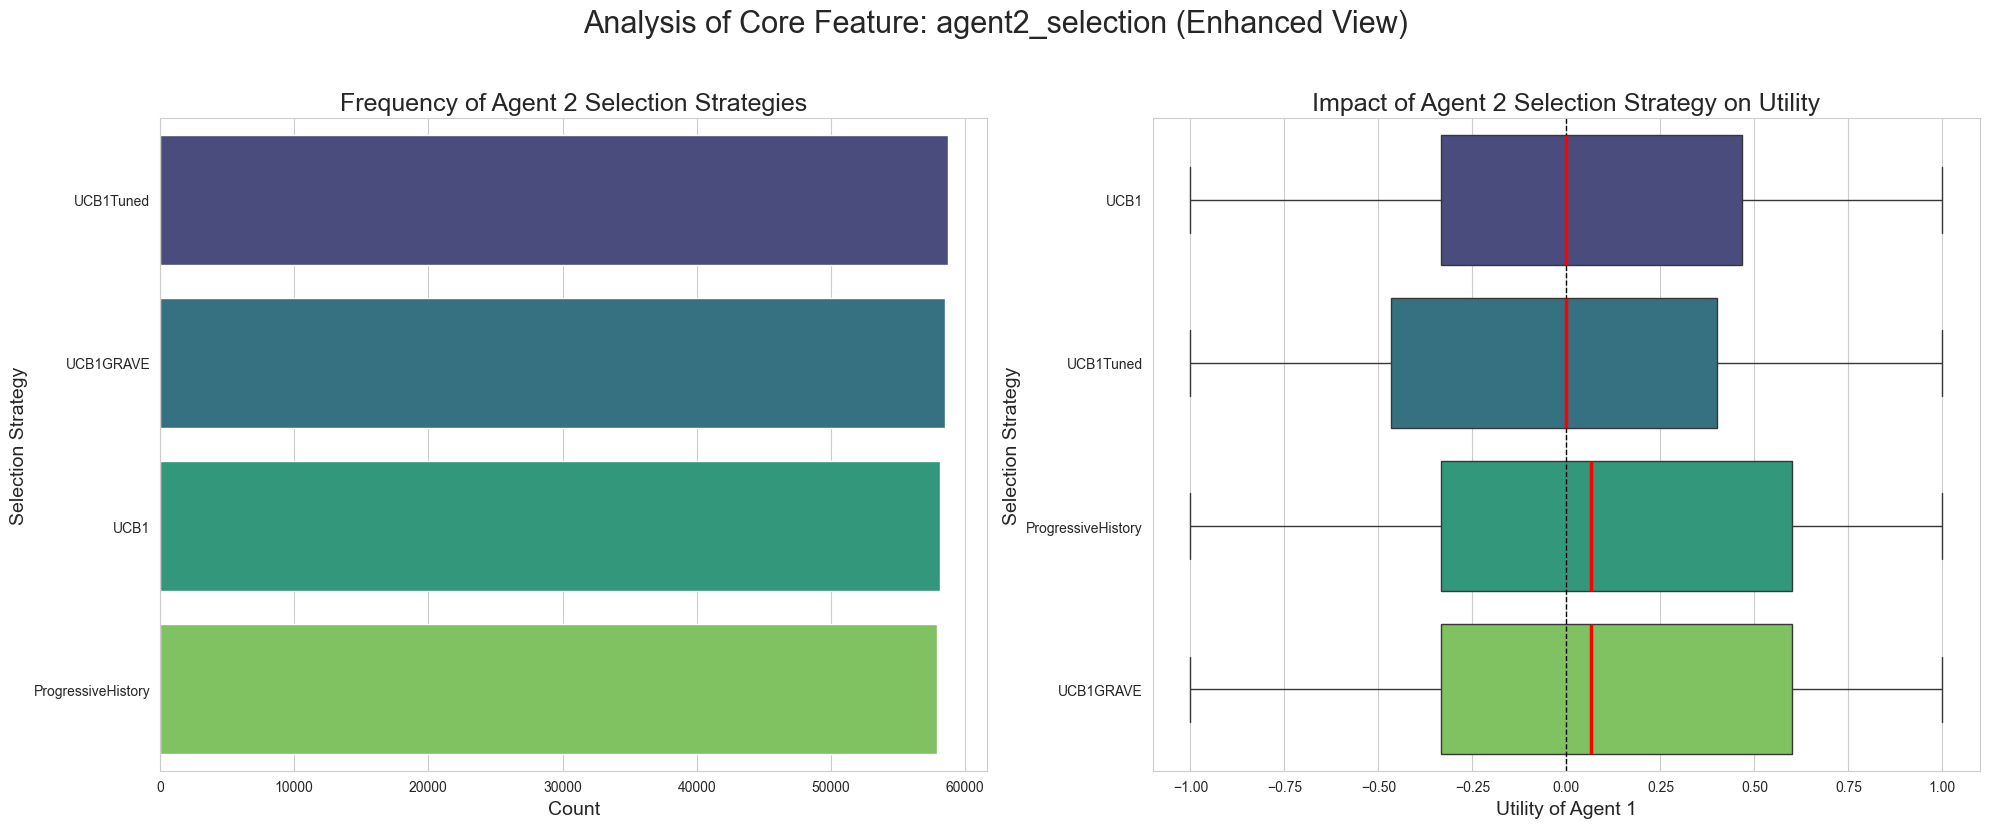

In [5]:
# --- Upgraded Visualization Code ---

# Let's analyze the 'selection' strategies for both agents with ENHANCED plots
for agent_num in [1, 2]:
    feature_to_analyze = f'agent{agent_num}_selection'
    
    plt.figure(figsize=(20, 8))
    
    # Plot 1: Countplot (remains the same)
    plt.subplot(1, 2, 1)
    sns.countplot(y=df_featured[feature_to_analyze], 
                  order=df_featured[feature_to_analyze].value_counts().index,
                  palette='viridis')
    plt.title(f'Frequency of Agent {agent_num} Selection Strategies')
    plt.xlabel('Count')
    plt.ylabel('Selection Strategy')

    # --- UPGRADED PLOT 2: Boxplot with Highlighted Median ---
    plt.subplot(1, 2, 2)
    order = df_featured.groupby(feature_to_analyze)['utility_agent1'].median().sort_values().index
    
    # Define properties for the median line to make it stand out
    medianprops = {'color': 'red', 'linewidth': 2.5, 'linestyle': '-'}
    
    sns.boxplot(x='utility_agent1', y=feature_to_analyze, data=df_featured, 
                order=order, 
                palette='viridis',
                medianprops=medianprops) # <-- APPLY THE NEW STYLE HERE
                
    plt.title(f'Impact of Agent {agent_num} Selection Strategy on Utility')
    plt.xlabel('Utility of Agent 1')
    plt.ylabel('Selection Strategy')
    # Add a reference line at zero
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    
    plt.suptitle(f'Analysis of Core Feature: {feature_to_analyze} (Enhanced View)', fontsize=22, y=1.03)
    plt.tight_layout()
    plt.show()

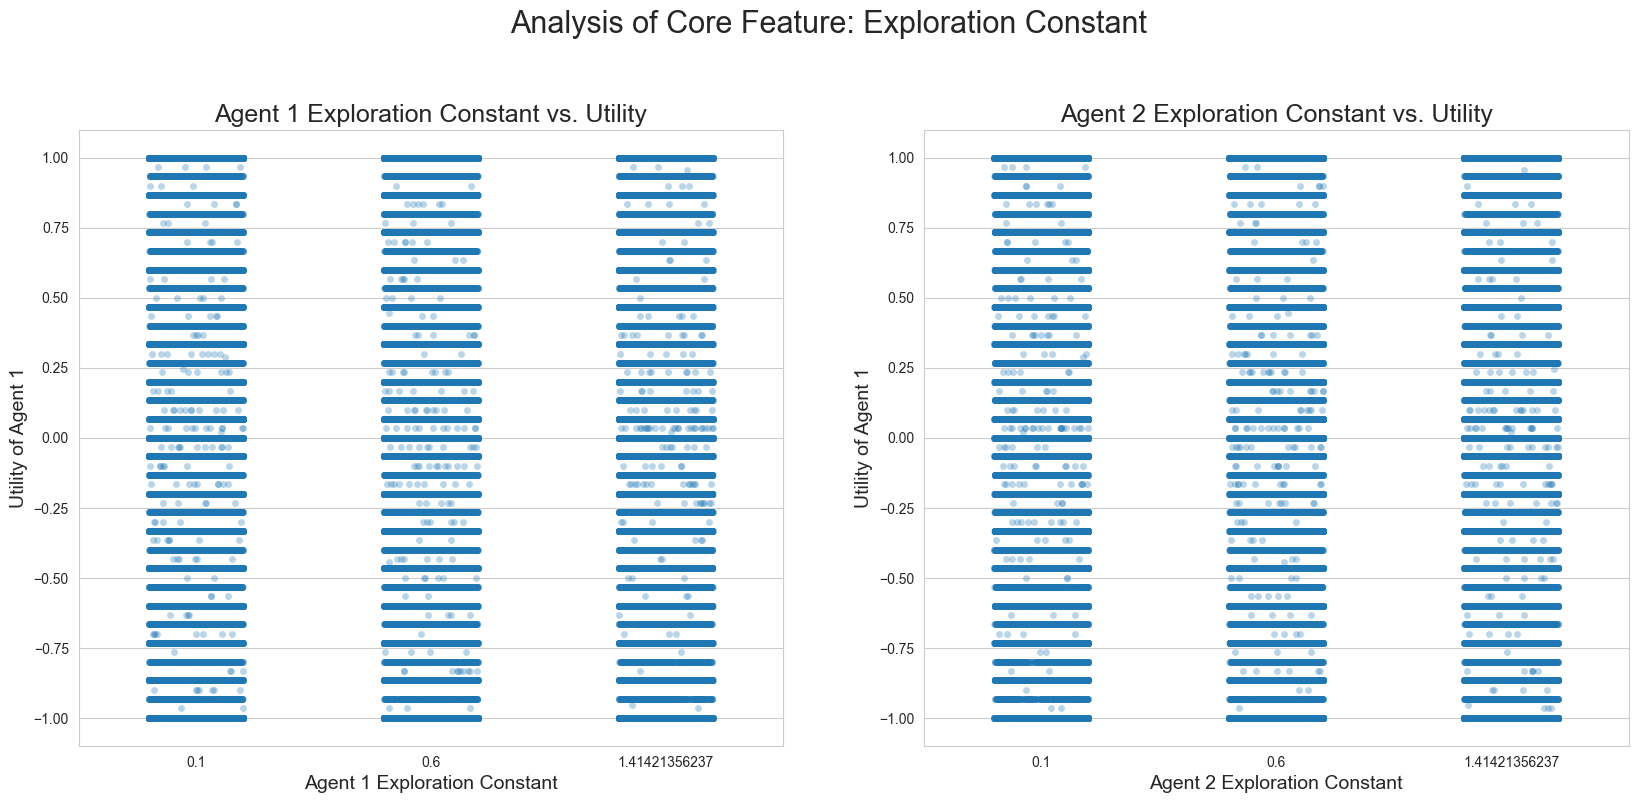

In [5]:
# Analyze the 'exploration' constant for both agents
plt.figure(figsize=(20, 8))

# Plot for Agent 1
plt.subplot(1, 2, 1)
sns.stripplot(data=df_featured, x='agent1_exploration', y='utility_agent1', alpha=0.3, jitter=0.2)
plt.title('Agent 1 Exploration Constant vs. Utility')
plt.xlabel('Agent 1 Exploration Constant')
plt.ylabel('Utility of Agent 1')

# Plot for Agent 2
plt.subplot(1, 2, 2)
sns.stripplot(data=df_featured, x='agent2_exploration', y='utility_agent1', alpha=0.3, jitter=0.2)
plt.title('Agent 2 Exploration Constant vs. Utility')
plt.xlabel('Agent 2 Exploration Constant')
plt.ylabel('Utility of Agent 1')


plt.suptitle('Analysis of Core Feature: Exploration Constant', fontsize=22, y=1.03)
plt.show()

/var/folders/h7/l0hj74bd2vqdz0r68qj78nd80000gn/T/ipykernel_17464/3550961501.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_featured, x='agent1_exploration', y='utility_agent1', palette='coolwarm')
/var/folders/h7/l0hj74bd2vqdz0r68qj78nd80000gn/T/ipykernel_17464/3550961501.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_featured, x='agent2_exploration', y='utility_agent1', palette='coolwarm')


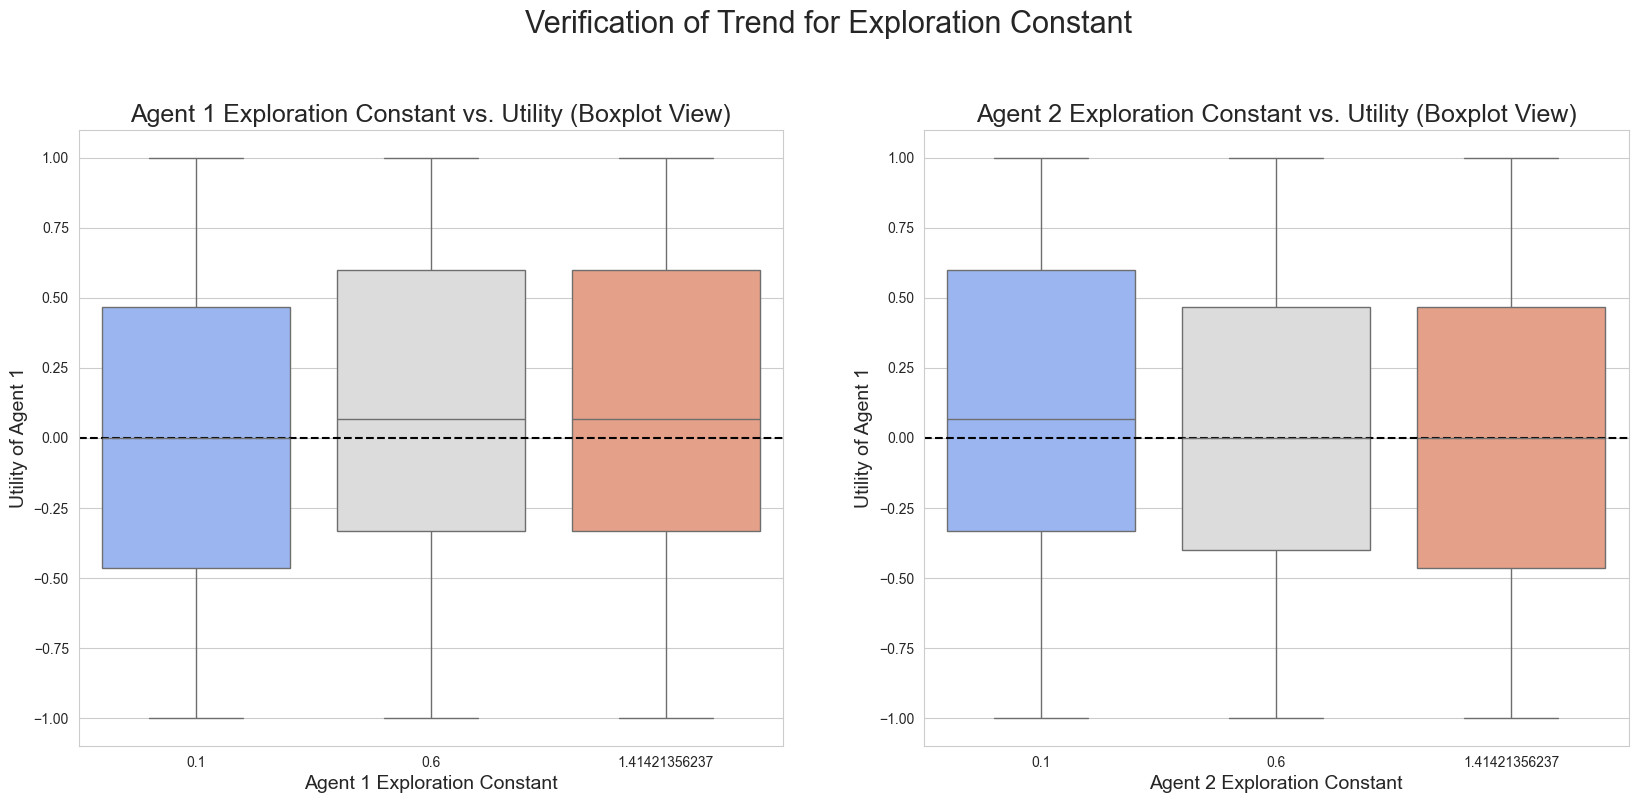

In [6]:
# --- Verification Step using Boxplot ---

plt.figure(figsize=(20, 8))

# Plot for Agent 1
plt.subplot(1, 2, 1)
sns.boxplot(data=df_featured, x='agent1_exploration', y='utility_agent1', palette='coolwarm')
plt.title('Agent 1 Exploration Constant vs. Utility (Boxplot View)')
plt.xlabel('Agent 1 Exploration Constant')
plt.ylabel('Utility of Agent 1')
# Add a horizontal line at y=0 for reference
plt.axhline(0, color='black', linestyle='--')

# Plot for Agent 2
plt.subplot(1, 2, 2)
sns.boxplot(data=df_featured, x='agent2_exploration', y='utility_agent1', palette='coolwarm')
plt.title('Agent 2 Exploration Constant vs. Utility (Boxplot View)')
plt.xlabel('Agent 2 Exploration Constant')
plt.ylabel('Utility of Agent 1')
# Add a horizontal line at y=0 for reference
plt.axhline(0, color='black', linestyle='--')

plt.suptitle('Verification of Trend for Exploration Constant', fontsize=22, y=1.03)
plt.show()

In [ ]:
# Ensure all columns are numeric for correlation calculation
# We will select only numeric types
numeric_df = df_featured.select_dtypes(include=np.number)

# Calculate correlations with the target variable
correlations = numeric_df.corr()['utility_agent1'].abs().sort_values(ascending=False)

print("--- Top 20 Features Most Correlated with Target (Absolute Value) ---")
print(correlations.head(20))

--- Starting Advanced EDA: Using LightGBM to find feature importances ---
Training a basic LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17867
[LightGBM] [Info] Number of data points in the train set: 233234, number of used features: 596
[LightGBM] [Info] Start training from score 0.044398
Training complete.

--- Top 30 Most Important Features According to LightGBM ---
                           feature  importance
610               agent2_selection         219
606               agent1_selection         195
430                    AdvantageP1         134
608                 agent1_playout         114
612                 agent2_playout          97
611             agent2_exploration          81
604              PlayoutsPerSecond          72
420       DurationTurnsNo

/var/folders/h7/l0hj74bd2vqdz0r68qj78nd80000gn/T/ipykernel_17767/3031653455.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(30), palette='rocket')


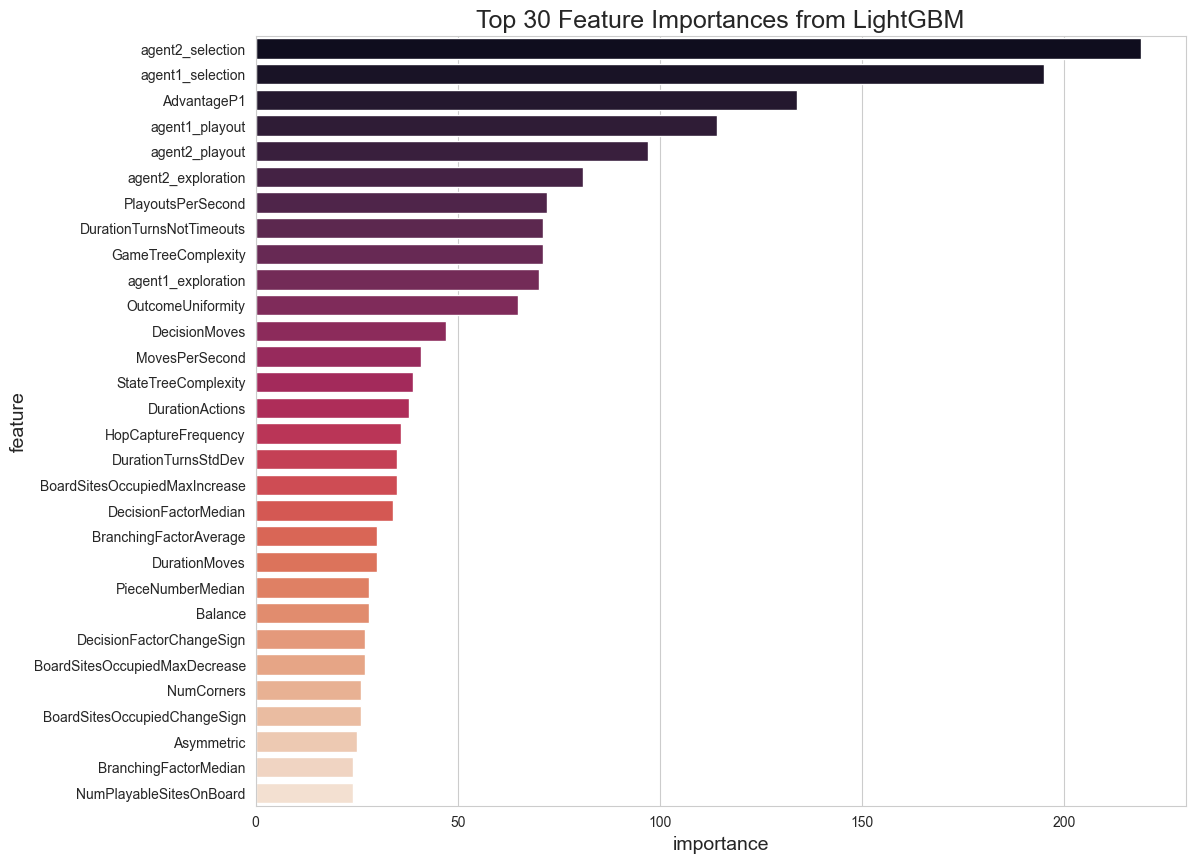

In [6]:
# --- Advanced EDA: Model-Based Feature Importance ---
import lightgbm as lgb

print("--- Starting Advanced EDA: Using LightGBM to find feature importances ---")

# 准备数据
# 我们需要将类别特征进行编码，以便LGBM处理
df_for_lgbm = df_featured.copy()

# 将对象类型（类别特征）转换为'category'类型，这是LGBM高效处理类别特征的方式
for col in df_for_lgbm.select_dtypes(include='object').columns:
    df_for_lgbm[col] = df_for_lgbm[col].astype('category')

# 定义特征 (X) 和目标 (y)
X = df_for_lgbm.drop(columns=['utility_agent1'])
y = df_for_lgbm['utility_agent1']

# 初始化一个基础的LightGBM回归模型
# random_state保证结果可复现
lgbm = lgb.LGBMRegressor(random_state=42)

# 训练模型
print("Training a basic LightGBM model...")
lgbm.fit(X, y)
print("Training complete.")

# 获取特征重要性
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': lgbm.feature_importances_
}).sort_values('importance', ascending=False)

# --- The "New & Improved" Treasure Map ---
print("\n--- Top 30 Most Important Features According to LightGBM ---")
print(feature_importance_df.head(30))

# 可视化特征重要性
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(30), palette='rocket')
plt.title('Top 30 Feature Importances from LightGBM')
plt.show()

In [15]:
def augment_data_with_flip_final(df: pd.DataFrame) -> pd.DataFrame:
    """
    Applies the flip/inversion data augmentation technique. This is the final, verified version.
    """
    print("--- Starting Flip/Inversion Data Augmentation (Verified Version) ---")
    
    # Create two separate copies from the start for clarity and safety
    df_original = df.copy()
    df_augmented = df.copy()
    
    # --- 1. Identify agent columns (No changes here, logic is robust) ---
    agent1_cols = [col for col in df.columns if 'agent1' in col and col != 'utility_agent1']
    agent2_cols = [col for col in df.columns if 'agent2' in col]
    
    if len(agent1_cols) != len(agent2_cols):
        raise ValueError("Mismatch in the number of agent1 and agent2 columns!")
    print(f"Found {len(agent1_cols)} pairs of agent features to swap.")
    
    # --- 2. Perform the swap on the augmented copy ---
    # Store agent1's original values from the augmented copy before overwriting
    agent1_original_values = df_augmented[agent1_cols].copy()
    
    # Swap operation
    df_augmented[agent1_cols] = df_augmented[agent2_cols].values
    df_augmented[agent2_cols] = agent1_original_values.values
    print("-> Swapped agent1 and agent2 features in the augmented set.")

    # --- 3. Invert values on the augmented copy ---
    if 'AdvantageP1' in df_augmented.columns:
        df_augmented['AdvantageP1'] = 1.0 - df_augmented['AdvantageP1']
        print("-> Inverted 'AdvantageP1' in the augmented set.")
    
    df_augmented['utility_agent1'] = -df_augmented['utility_agent1']
    print("-> Inverted target 'utility_agent1' in the augmented set.")
    
    # --- 4. Add augmentation flags ---
    df_original['is_augmented'] = 0
    df_augmented['is_augmented'] = 1
    print("-> Added 'is_augmented' flags to both sets.")
    
    # --- 5. Concatenate and return ---
    df_final = pd.concat([df_original, df_augmented], ignore_index=True)
    
    print(f"✅ Augmentation complete. New dataset shape: {df_final.shape}")
    
    return df_final

# -----------------------------------------------------
# 这里是你定义整个 def augment_data_with_flip_final(...): 函数的代码
# ...
# ... 函数定义结束
# -----------------------------------------------------


# --- 缺失的关键步骤：调用函数 ---

# 使用我们之前准备好的、经过清洗和初步特征工程的 df_featured 作为输入
print("Now, calling the augmentation function...")
df_final_for_modeling = augment_data_with_flip_final(df_featured) 

# Define the key columns we want to inspect
key_cols = [
    'agent1_selection', 'agent2_selection',
    'agent1_exploration', 'agent2_exploration',
    'AdvantageP1', 'utility_agent1', 'is_augmented'
]

print("--- Head (Original Data) of Key Columns ---")
print(df_final_for_modeling[key_cols].head())

print("\n--- Tail (Augmented Data) of Key Columns ---")
print(df_final_for_modeling[key_cols].tail())

Now, calling the augmentation function...
--- Starting Flip/Inversion Data Augmentation (Verified Version) ---
Found 4 pairs of agent features to swap.
-> Swapped agent1 and agent2 features in the augmented set.
-> Inverted 'AdvantageP1' in the augmented set.
-> Inverted target 'utility_agent1' in the augmented set.
-> Added 'is_augmented' flags to both sets.
✅ Augmentation complete. New dataset shape: (466468, 616)
--- Head (Original Data) of Key Columns ---
     agent1_selection    agent2_selection agent1_exploration  \
0  ProgressiveHistory  ProgressiveHistory                0.1   
1  ProgressiveHistory           UCB1GRAVE                0.1   
2  ProgressiveHistory                UCB1                0.1   
3  ProgressiveHistory                UCB1                0.1   
4  ProgressiveHistory           UCB1GRAVE                0.1   

  agent2_exploration  AdvantageP1  utility_agent1  is_augmented  
0                0.6          0.5       -0.466667             0  
1                0.

In [16]:
# --- Final Step: Persist the Augmented Dataset for Team Use ---

# Define the output path. It's good practice to save it in the 'data' directory.
output_path = '../data/train_augmented.csv'

print(f"\n--- Saving the final augmented dataset to a file ---")
print(f"Dataset shape: {df_final_for_modeling.shape}")
print(f"Saving to: {output_path}")

# Save the DataFrame to a CSV file. `index=False` is important to avoid saving the pandas index as a column.
df_final_for_modeling.to_csv(output_path, index=False)

print(f"✅ Successfully saved the augmented dataset.")
print("\nThis file is now ready to be used by the Feature Engineering and Modeling teams as their new training set.")


--- Saving the final augmented dataset to a file ---
Dataset shape: (466468, 616)
Saving to: ../data/train_augmented.csv
✅ Successfully saved the augmented dataset.

This file is now ready to be used by the Feature Engineering and Modeling teams as their new training set.
